In [3]:
import numpy as np
import pandas as pd
import csv
import torch
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

df = pd.read_csv('/mnt/infonas/blossom/pbansal/dataset/jantahack/train.csv')

In [45]:
week_mapping = dict({})
for i,x in enumerate(df.week.unique()):
    week_mapping[x] = i
store_mapping = dict({})
for i,x in enumerate(df.store_id.unique()):
    store_mapping[x] = i
sku_mapping = dict({})
for i,x in enumerate(df.sku_id.unique()):
    sku_mapping[x] = i
df['encoded_week'] = df.apply(lambda x : week_mapping[x['week']],axis=1)
df['encoded_store'] = df.apply(lambda x : store_mapping[x['store_id']],axis=1)
df['encoded_sku'] = df.apply(lambda x : sku_mapping[x['sku_id']],axis=1)
data = df[["encoded_week","encoded_store","encoded_sku","units_sold"]]

In [5]:
out_array = np.zeros((130,76,28)).astype(np.float32)
for x in df.iterrows():
    out_array[x[1]['encoded_week'],x[1]['encoded_store'],x[1]['encoded_sku']] = x[1]['units_sold']

In [46]:
data

,encoded_week,encoded_store,encoded_sku,units_sold
0,0,0,0,20
1,0,0,1,28
2,0,0,2,19
3,0,0,3,44
4,0,0,4,52
...,...,...,...,...
150145,129,75,7,38
150146,129,75,8,30
150147,129,75,16,31
150148,129,75,17,12


In [57]:
np.random.seed(1)

np.save('dataset/2djantahack_complete',out_array)
np.save('dataset/1djantahack_complete',np.reshape(out_array,(out_array.shape[0],-1)))
all_examples = data.to_numpy()[:,:3]
np.random.shuffle(all_examples)
np.save('dataset/2djantahack_test_examples.npy',all_examples[int(4*all_examples.shape[0]/5):])
np.save('dataset/2djantahack_train_examples.npy',all_examples[:int(4*all_examples.shape[0]/5)])
temp = deepcopy(all_examples)
temp[:,1] = all_examples[:,1]*28 + all_examples[:,2]
temp = temp[:,:2]
np.save('dataset/1djantahack_test_examples.npy',temp[int(4*all_examples.shape[0]/5):])
np.save('dataset/1djantahack_train_examples.npy',temp[:int(4*all_examples.shape[0]/5)])

num_points = int(130*76*28)
all_examples = np.zeros((num_points,3))
id_ = 0
for i in range(130):
    for j in range(76):
        for k in range(28):
            all_examples[id_,0] = i
            all_examples[id_,1] = j
            all_examples[id_,2] = k
            id_ += 1
np.save('dataset/2djanta_all_examples.npy',all_examples)

<AxesSubplot:>

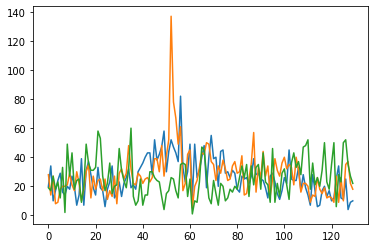

In [13]:
import seaborn as sns
sns.lineplot(x = np.arange(130),y=out_array[:,0,0])
sns.lineplot(x = np.arange(130),y=out_array[:,0,1])
sns.lineplot(x = np.arange(130),y=out_array[:,0,2])

In [71]:
row_sums = np.std(out_array,axis=0,keepdims=True)
row_sums[row_sums==0] = 1
norm_out_array = out_array / row_sums
np.save('dataset/jantahack_noshift_numpy_complete',norm_out_array)
np.save('dataset/jantahack_nonorm_numpy_complete',out_array)

In [73]:
all_examples = data.loc[(data['encoded_week'] < 128) & (data['encoded_week'] > 1)].to_numpy()
np.random.shuffle(all_examples)
np.save('dataset/jantahack_test_examples.npy',all_examples[int(9*all_examples.shape[0]/10):])
np.save('dataset/jantahack_train_examples.npy',all_examples[:int(2*all_examples.shape[0]/3)])

In [70]:
all_examples = data.to_numpy()
np.unique(all_examples[:,1:3],axis=0)

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       ...,
       [75, 16],
       [75, 17],
       [75, 22]])

In [6]:
def test_ (model,val_set):
    device = torch.device('cuda:1')
    batch_size = 64
    preds = []
    val_loader = torch.utils.data.DataLoader(val_set,shuffle=True,batch_size = batch_size,drop_last=False)
    model = model.to(device)
    loss_ = 0
    for x,y,index in val_loader :
        with torch.no_grad():
            x = x.to(device)
            y_pred,var = model(x)
            y = y.to(device)
            pred = ((y_pred-y)**2)/var + var
            loss_ +=  pred.mean().data*x.shape[0]
            pred = torch.exp(-0.5*pred).data
            for i in range(x.shape[0]):
                preds.append(((int(index[0][i]),int(index[1][i]),int(index[2][i])),float(pred[i]),float(var[i]),float(y_pred[i]),x[i].cpu()))
    loss_ = loss_/int(len(val_set))
    return loss_,np.array(preds)

In [9]:
import helper
import importlib
importlib.reload(helper)
val_set = helper.Dataset_('dataset/jantahack_noshift_numpy_complete.npy','dataset/jantahack_test_examples.npy')
epoch = 99
model = helper.NN()
model.load_state_dict(torch.load('/mnt/infonas/blossom/pbansal/janta_checkpoints/checkpoint_%d'%epoch))
_,truly_inlier_scores = test_(model,val_set)

loading dataset


/mnt/a99/d0/pbansal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [3]:
from ConditionalPredictor import helper as condHelper
import importlib
importlib.reload(condHelper)

val_set = condHelper.Dataset_('dataset/jantahack_noshift_numpy_complete.npy','dataset/jantahack_test_examples.npy')
epoch = 15
model = condHelper.NN_Janta()
model.load_state_dict(torch.load('/mnt/infonas/blossom/pbansal/janta_checkpoints_cond_pred/checkpoint_%d'%epoch))
_,cond_truly_inlier_scores = test_(model,val_set)

loading dataset


NameError: name 'test_' is not defined

In [5]:
torch.save(model.feat_embedd[1],'saved_embeddings/janta_shop.pt')
torch.save(model.feat_embedd[2],'saved_embeddings/janta_sku.pt')

In [19]:
temp_cond = cond_truly_inlier_scores[np.argsort(cond_truly_inlier_scores[:,1])]
temp_context = truly_inlier_scores[np.argsort(truly_inlier_scores[:,1])]
complete = np.load('dataset/jantahack_noshift_numpy_complete.npy')

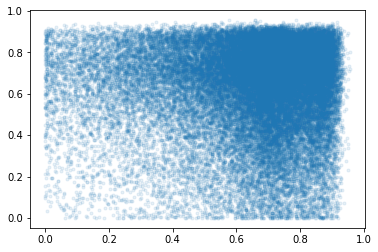

In [60]:
plt.scatter(x=truly_inlier_scores[:,1],y=cond_truly_inlier_scores[:,1],alpha=0.1,marker='.')

In [54]:
print ("Cond Rank, Context Rank")
# for i1 in range(20):
#     for i2,x in enumerate(temp_context):
#         if (x[0] == temp_cond[i1][0]):
#             print (i1,i2)

for i1 in range(20):
    for i2,x in enumerate(temp_cond):
        if (x[0] == temp_context[i1][0]):
            print (i2,i1)

Cond Rank, Context Rank
0 0
9 1
5 2
6 3
41 4
2 5
1 6
60 7
931 8
57 9
37 10
10 11
630 12
152 13
1137 14
15 15
166 16
113 17
14 18
49 19


In [58]:
#x,i = temp_cond,1137
x,i = temp_context,14
visualise(x[i],complete)

Index is :  (32, 48, 3) , Inlier Prob : 0.000020
Pred Value is : 3.033348,Deviation is : 0.653006
True Value : 114, Normalised Value : 6.731722
Input Features : 
tensor([ 4.5469,  2.7163,  3.7202,  2.7754, -0.2463,  0.2147,  0.1257,  0.1617,
        -0.8501,  0.0368, -0.0700,  0.0332,  1.0396,  0.5421,  0.3443,  0.4803,
         1.2986,  1.1093,  1.0324,  1.0435])
Time Series : 
[3.3068109 2.2439072 2.5982084 1.5943552 2.5391583 4.783066  4.1925635
 4.842116  4.783066  3.7201622 3.3068109 3.4249113 3.0115597 2.5391583
 1.8305559 2.480108  2.7753592 4.1925635 3.5430117 2.5391583 5.4326177
 3.4839613 2.7753592 3.1296601 3.1296601 3.6611118 4.251614  3.4249113
 5.137367  4.4878144 3.7201622 4.546865  6.731722  2.7163088 2.7753592
 4.960216  2.8344092 2.7163088 3.4249113 3.6611118 4.310664  2.125807
 3.07061   3.3068109 3.1296601 3.5430117 2.3620076 3.1296601 2.480108
 2.480108  1.7124556 2.9525096 4.0744634 2.5391583 3.0115597 6.790772
 2.8934593 4.0744634 2.5391583 3.7201622 3.5430117 2.

,time-2,time-1,time,time+1,time+2
0,35.0,76.0,55.0,64.0,64.0
1,38.0,53.0,85.0,39.0,50.0
2,41.0,47.0,50.0,45.0,36.0
3,63.0,77.0,114.0,46.0,47.0
4,47.0,41.0,52.0,40.0,33.0
5,56.0,70.0,84.0,82.0,74.0
6,28.0,54.0,36.0,42.0,38.0
7,34.0,292.0,38.0,25.0,17.0
8,37.0,310.0,26.0,15.0,42.0
9,39.0,23.0,29.0,35.0,21.0


encoded_sku fixed as : 3


,time-2,time-1,time,time+1,time+2
0,43.0,38.0,34.0,25.0,43.0
1,112.0,127.0,119.0,103.0,113.0
2,61.0,61.0,56.0,49.0,56.0
3,35.0,29.0,42.0,36.0,23.0
4,147.0,145.0,169.0,146.0,105.0
5,49.0,78.0,65.0,39.0,61.0
6,118.0,172.0,122.0,133.0,84.0
7,44.0,42.0,37.0,49.0,30.0
8,25.0,32.0,32.0,55.0,36.0
9,97.0,123.0,83.0,64.0,80.0


In [25]:
def visualise(in_,norm_out_array):
    index = in_[0]
    print ("Index is : ",index,", Inlier Prob : %f"%(in_[1]))
    print ("Pred Value is : %f,Deviation is : %f"%(in_[3],in_[2]))
    true_value = int(data.loc[(data["encoded_week"] == index[0]) & (data["encoded_store"] == index[1]) & (data["encoded_sku"] == index[2])]['units_sold'])
    time_series_value = norm_out_array[:,index[1],index[2]]
    normalised_value = time_series_value[index[0]]
    print ("True Value : %d, Normalised Value : %f"%(true_value,normalised_value))
    print ("Input Features : ")
    print (in_[4])

    print ("Time Series : ")
    print (time_series_value)
    temp_array = np.zeros((5,266+266))
    temp_data = data.loc[(data["encoded_week"] >= index[0]-2) & (data["encoded_week"] <= index[0]+2) & (data["encoded_store"] == index[1])]
    for x in temp_data.iterrows():
        temp_array[int(x[1]['encoded_week'])-index[0]+2][int(x[1]['encoded_sku'])] = x[1]['units_sold']    

    temp_data = data.loc[(data["encoded_week"] >= index[0]-2) & (data["encoded_week"] <= index[0]+2) & (data["encoded_sku"] == index[2])]
    for x in temp_data.iterrows():
        temp_array[int(x[1]['encoded_week'])-index[0]+2][266+int(x[1]['encoded_store'])] = x[1]['units_sold']    
    
    pd.set_option('display.max_rows', None)
    print ("encoded_store fixed as : %d"%index[1])
    temp_temp_data = pd.DataFrame(data=temp_array[:,:266].transpose(),index=np.arange(266),columns=['time-2','time-1','time','time+1','time+2'])
    display(temp_temp_data.loc[(temp_temp_data['time-2']!=0)|(temp_temp_data['time-1']!=0)|(temp_temp_data['time']!=0)|(temp_temp_data['time+1']!=0)|(temp_temp_data['time+2']!=0)])
    print ("encoded_sku fixed as : %d"%index[2])
    temp_temp_data = pd.DataFrame(data=temp_array[:,266:].transpose(),index=np.arange(266),columns=['time-2','time-1','time','time+1','time+2'])
    display(temp_temp_data.loc[(temp_temp_data['time-2']!=0)|(temp_temp_data['time-1']!=0)|(temp_temp_data['time']!=0)|(temp_temp_data['time+1']!=0)|(temp_temp_data['time+2']!=0)])
    return

In [20]:
from scipy.stats import norm
norm.ppf(0.05)

-1.6448536269514729

In [42]:
a = np.random.rand(4,6,5)
a

array([[[0.54017222, 0.91066244, 0.65710756, 0.66510466, 0.64861559],
        [0.70562858, 0.76136931, 0.72107595, 0.65321369, 0.82778584],
        [0.99669799, 0.7344307 , 0.79461561, 0.4517561 , 0.97861087],
        [0.82122365, 0.96459913, 0.81614016, 0.86730542, 0.40833494],
        [0.44140895, 0.33742961, 0.93887977, 0.45027763, 0.91468333],
        [0.41358068, 0.57999066, 0.96641342, 0.99807716, 0.73026103]],

       [[0.26696705, 0.06459247, 0.6995356 , 0.65201676, 0.9928125 ],
        [0.86305455, 0.2901498 , 0.26243215, 0.72806808, 0.71526876],
        [0.45826672, 0.11507728, 0.32654808, 0.374558  , 0.50131023],
        [0.77563388, 0.0170486 , 0.69268042, 0.8413135 , 0.35990342],
        [0.99621823, 0.17135542, 0.16061986, 0.65475523, 0.33996528],
        [0.07952897, 0.55486455, 0.38946226, 0.66810496, 0.6300951 ]],

       [[0.62758591, 0.6076867 , 0.2479199 , 0.52629374, 0.51465859],
        [0.27678634, 0.6713959 , 0.85903403, 0.48816354, 0.08703827],
        [0.69168

In [52]:
temp = np.argsort(a,axis=0)
ranks = np.empty_like(temp)
print(np.put_along_axis(ranks, temp, np.repeat(np.repeat(np.arange(temp.shape[0])[:,None],temp.shape[1],axis=1)[:,:,None], temp.shape[2], axis=2), axis=0))

None


In [67]:
print (a)
print (np.reshape(a,(a.shape[0],-1)))

[[[0.54017222 0.91066244 0.65710756 0.66510466 0.64861559]
  [0.70562858 0.76136931 0.72107595 0.65321369 0.82778584]
  [0.99669799 0.7344307  0.79461561 0.4517561  0.97861087]
  [0.82122365 0.96459913 0.81614016 0.86730542 0.40833494]
  [0.44140895 0.33742961 0.93887977 0.45027763 0.91468333]
  [0.41358068 0.57999066 0.96641342 0.99807716 0.73026103]]

 [[0.26696705 0.06459247 0.6995356  0.65201676 0.9928125 ]
  [0.86305455 0.2901498  0.26243215 0.72806808 0.71526876]
  [0.45826672 0.11507728 0.32654808 0.374558   0.50131023]
  [0.77563388 0.0170486  0.69268042 0.8413135  0.35990342]
  [0.99621823 0.17135542 0.16061986 0.65475523 0.33996528]
  [0.07952897 0.55486455 0.38946226 0.66810496 0.6300951 ]]

 [[0.62758591 0.6076867  0.2479199  0.52629374 0.51465859]
  [0.27678634 0.6713959  0.85903403 0.48816354 0.08703827]
  [0.69168215 0.36313543 0.76184486 0.29585205 0.75721035]
  [0.38101412 0.31548963 0.76144522 0.98173174 0.50173081]
  [0.05457362 0.31233196 0.98704786 0.53183049 0.095